In [1]:
#imports
from __future__ import division
from contextlib import contextmanager
from collections import namedtuple, defaultdict

import pandas as pd
import numpy as np
import scipy as sp

from polara.recommender.models import RecommenderModel, SVDModel, PopularityModel, RandomModel
from polara.recommender.data import RecommenderData
from polara.tools.printing import suppress_stdout
from polara.lib.similarity import combine_similarity_data
from evaluation import evaluate_hits
from tools import get_ml_data

from models_sparse import HybridSVD, FeatureSimilarityMixin

from tqdm import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class SimilarityDataModel(FeatureSimilarityMixin, RecommenderData): pass

In [3]:
class ContentBased(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBased, self).__init__(*args, **kwargs)
        self.method = 'CB'

    def build(self, *args, **kwargs):
        # use copy to prevent contaminating original data
        self.item_similarity_matrix = self.data.item_similarity.copy()
        self.item_similarity_matrix.setdiag(0) # exclude self-links
        self.item_similarity_matrix.eliminate_zeros()
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        # test matrix is in CSR format
        scores = self.item_similarity_matrix.dot(test_matrix.T).T
        return scores, slice_data

In [4]:
file_path = 'datasets/ml-1m.zip'
meta_path = 'datasets/meta_info_ml1m.csv'
id_fixes_path = 'datasets/ml1m_sub.csv'

data, genres, meta_info = get_ml_data(file_path, meta_path, id_fixes_path=id_fixes_path)

In [5]:
ml_data = data.query('rating>=4').assign(rating=1)

In [6]:
ml_data.userid.nunique()

6038

In [7]:
ml_data.movieid.nunique()

3532

In [8]:
100 * ml_data.shape[0] / (ml_data.userid.nunique()*ml_data.movieid.nunique())

2.697524961765369

In [6]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

sim_type = {'cast':jw}
item_similarity = combine_similarity_data(meta_info[sim_type.keys()], similarity_type=sim_type, weights=None)

In [7]:
similarities = {'userid': None, 'movieid': item_similarity}
sim_indices = {'userid': None, 'movieid': meta_info.index}

# Quick test

In [12]:
data_model = SimilarityDataModel(similarities, sim_indices, ml_data, 'userid', 'movieid', 'rating', seed=42)

In [13]:
data_model.holdout_size = 1
data_model.random_holdout = True
data_model.test_unseen_users = False
data_model.test_sample = None
data_model.verbose = True

In [14]:
data_model.prepare()

Preparing data...
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 unique userid's within 1 holdout interactions were filtered. Reason: not in the training data.


In [15]:
psvd = SVDModel(data_model)

In [16]:
psvd.build()

PureSVD training time: 0.191961050034s


In [17]:
psvd_hits = evaluate_hits(data_model.test.evalset, 'userid', 'movieid', psvd.recommendations)

In [18]:
psvd_hits.getnnz(axis=1).mean()

0.16182572614107885

In [19]:
hsvd = HybridSVD(data_model)

In [20]:
hsvd.build()

Updating movieid similarity matrix
Performing sparse Cholesky decomposition for movieid similarity
HybridSVD training time: 2.8961379528s


In [21]:
hsvd_hits = evaluate_hits(data_model.test.evalset, 'userid', 'movieid', hsvd.recommendations)

In [22]:
hsvd_hits.getnnz(axis=1).mean()

0.15435684647302905

In [ ]:
cb = ContentBased(data_model)
cb.build()

In [24]:
cb_hits = evaluate_hits(data_model.test.evalset, 'userid', 'movieid', cb.recommendations)

/home/evfro/miniconda/envs/polara_env/lib/python2.7/site-packages/polara/recommender/models.py:380: FutureWarning: pandas.lib.fast_zip is deprecated and will be removed in a future version.
  recs_idx = pd.lib.fast_zip(list(recs.nonzero())) #larger


In [25]:
cb_hits.getnnz(axis=1).mean()

0.034024896265560163

In [ ]:
mpop = PopularityModel(data_model)
mpop.build()

In [27]:
mpop_hits = evaluate_hits(data_model.test.evalset, 'userid', 'movieid', mpop.recommendations)

In [28]:
mpop_hits.getnnz(axis=1).mean()

0.082987551867219914

In [29]:
rndm = RandomModel(data_model, seed=42)
rndm.build()

In [30]:
rndm_hits = evaluate_hits(data_model.test.evalset, 'userid', 'movieid', rndm.recommendations)
rndm_hits.getnnz(axis=1).mean()

0.0024896265560165973

# Experiments

In [33]:
def replicate_models(constructor, n, *args, **kwargs):
    config = kwargs.pop('config', [])
    replicas = [constructor(*args, **kwargs) for i in xrange(n)]
    try_set_config(replicas, config)
    return replicas

In [128]:
def build_models(models, config=None, verbose=False):
    try_set_config(models, config)
    for model in models:
        model.verbose = verbose
        model.build()

def try_set_config(models, config, force=False):
    if config is None:
        return
    for model, model_config in zip(models, config):
        if not model_config:
            continue
        for k, v in model_config.iteritems():
            if hasattr(model, k) or force:
                setattr(model, k, v)
            else:
                if model.vebose:
                    msg = 'Unable to set {} attribute for model {}'
                    print msg.format(k, model)

def set_models_attribute(models, attr_name, attr_val):
    for model in models:
        setattr(model, attr_name, attr_val)

def validate_model_settings(models, config, attr_name, no_attr_action):
    valid_models = []
    valid_config = []
    other_models = []
    other_config = []
    config = config or [None]*len(models)
    for i, model in enumerate(models):
        if not hasattr(model, attr_name):
            if no_attr_action is 'ignore':
                pass
            elif no_attr_action is 'process':
                other_models.append(model)
                other_config.append(config[i])
            elif no_attr_action is 'raise':
                raise AttributeError('Model {} has no {} dependence'.format(attr_name, model.method))
            else:
                raise ValueError('Unrecognized value for no_rank argument.')
        else:
            valid_models.append(model)
            valid_config.append(config[i])
    return (valid_models, valid_config), (other_models, other_config)

In [37]:
def evaluator(test_data, key, target):
    def eval_func(model, metrics):
        scores = {}
        recommendations = model.recommendations[..., :model.topk]
        hits = evaluate_hits(test_data, key, target, recommendations)
        if 'HR' in metrics:
            # calculate hit rate
            hit_rate = hits.getnnz(axis=1).mean()
            scores['HR'] = hit_rate
        if 'MRR' in metrics:
            # calculate hit reciprocal rank
            hits.data = 1. / hits.data
            scores['MRR'] = hits.max(axis=1).mean()
        if 'COV' in metrics:
            # assortment coverage
            scores['COV'] = np.unique(recommendations).size
        return scores
    return eval_func

def evaluate_models(models, metrics, eval_func):
    res = {}
    for model in models:
        eval_func = eval_func or model.__class__.evaluate # breaks if model has custom evalute() method
        res[model.method] = eval_func(model, metrics)
    return res

In [133]:
def run_cv_experiment(models, data_model, metrics, param_tuple, models_configuration=None, no_param_action='raise', verbose=False, folds=None):
    cv_results = defaultdict(lambda: defaultdict(dict))
    folds = folds or range(1, int(1 / data_model.test_ratio)+1)
    data_model.verbose = verbose
    param_name, param_vals = param_tuple
    
    param_vals_sorted = list(reversed(sorted(param_vals))) # avoids recomputations when possible
    (valid_models, valid_config), (other_models, other_config) = validate_model_settings(models, models_configuration, param_name, no_param_action)
        
    for fold in tqdm_notebook(folds, desc='fold'):
        data_model.test_fold = fold
        data_model.prepare()

        eval_func = evaluator(data_model.test.evalset, 'userid', 'movieid')
            
        if other_models:
            build_models(other_models, config=other_config, verbose=verbose)
            other_scores = evaluate_models(other_models, metrics, eval_func)
            key = 'no_{}'.format(param_name)
            cv_results[fold][key].update(other_scores)

        set_models_attribute(valid_models, param_name, max(param_vals)) # avoids recomputations when possible
        build_models(valid_models, config=valid_config, verbose=verbose)
        for param_val in param_vals_sorted:
            set_models_attribute(valid_models, param_name, param_val)
            valid_scores = evaluate_models(valid_models, metrics, eval_func)
            cv_results[fold][param_val] = valid_scores

    return cv_results

In [150]:
def get_results_dataframe(cv_results, param_tuple, folds=None):
    df_from_dict = pd.DataFrame.from_dict
    param_name, param_vals = param_tuple
    param_vals = param_vals or ['no_{}'.format(param_name)]
    result = pd.concat({(i, j): df_from_dict(cv_results[i][j]) for i, p in cv_results.iteritems() for j in p if j in param_vals}, names=['fold', param_name]).unstack()
    return result

In [40]:
seed = 42

data_model = SimilarityDataModel(similarities, sim_indices, ml_data, 'userid', 'movieid', 'rating', seed=seed)
data_model.holdout_size = 1
data_model.random_holdout = True
data_model.test_unseen_users = False
data_model.test_sample = None

In [41]:
# create recommenders
cb = ContentBased(data_model)
mpop = PopularityModel(data_model)
rndm = RandomModel(data_model, seed=seed)
psvd = SVDModel(data_model)

In [42]:
baselines = [mpop, rndm, cb]

features_weights = [0.999, 0.5, 0.1]
hybrid_config = [{'features_weight':w, 'method': r'HybridSVD ($\alpha={}$)'.format(w)} for w in features_weights]
hybrids = replicate_models(HybridSVD, len(features_weights), data_model, config=hybrid_config)

models = baselines + [psvd] + hybrids
models_config = [{'topk':10}]*len(models)

for model in models:
    print model.method,

MP RND CB PureSVD HybridSVD ($\alpha=0.999$) HybridSVD ($\alpha=0.5$) HybridSVD ($\alpha=0.1$)


In [ ]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3200]

cv_results = run_cv_experiment(models, data_model, metrics, ('rank', ranks), models_configuration=models_config, no_param_action='process', verbose=False)

A Jupyter Widget

In [345]:
rank_cv_results = get_results_dataframe(cv_results, ('rank', ranks))
base_cv_results = get_results_dataframe(cv_results, ('rank', None))

In [348]:
rank_cv_results.to_csv('Standard_SVD_CV_results_ML.csv', index=True)

In [349]:
base_cv_results.to_csv('Standard_Baseline_CV_results_ML.csv', index=True)

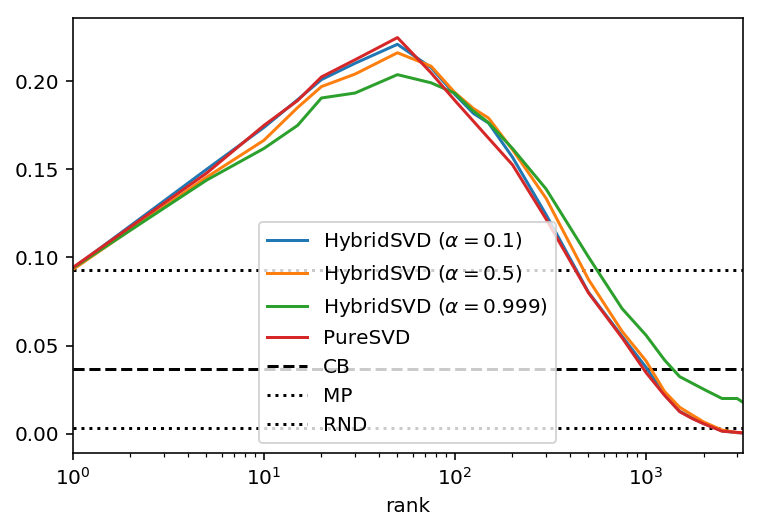

In [350]:
ax = rank_cv_results.xs('HR', 1, 1).mean(level='rank').plot(logx=True)

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs('HR', 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

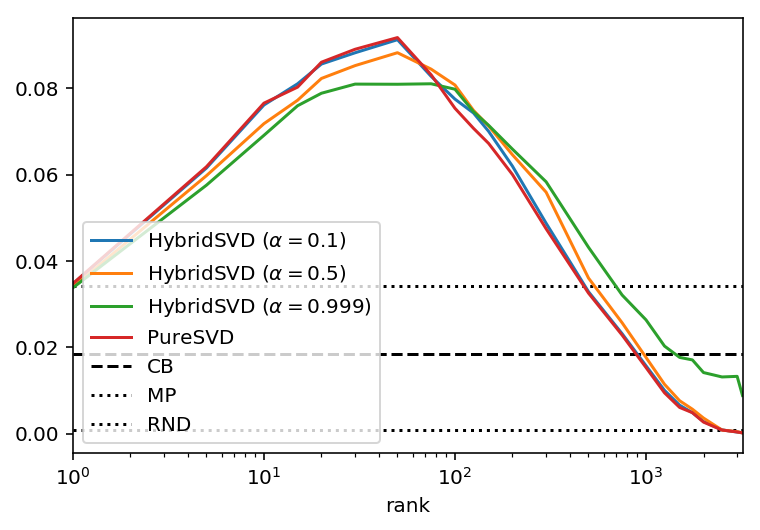

In [351]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

# FM

In [ ]:
# %env OMP_NUM_THREADS=16
from polara.tools.graphlab.glwrapper import GraphlabFactorization
import graphlab as gl

## Parameter search

In [186]:
from sklearn.model_selection import ParameterGrid

In [187]:
def run_parameter_search(model, data_model, metrics, params_grid, search_space_size=None, verbose=False, seed=None):
    grid_results = {}
    
    data_model.verbose = verbose
    data_model.update()
    eval_func = evaluator(data_model.test.evalset, 'userid', 'movieid')
    
    if search_space_size:
        random_state = np.random.RandomState(seed) if seed else np.random
        param_choice = random_state.choice(len(params_grid), search_space_size, replace=False)
    else:
        param_choice = range(len(params_grid))

    for p in tqdm_notebook(param_choice, desc='params'):
        param_set = params_grid[p]
        build_models([model], config=[param_set], verbose=verbose)

        key = tuple([(''.join([s[0] for s in p.split('_')]), v) for p, v in param_set.iteritems()])
        grid_results[key] = eval_func(model, metrics)
    return grid_results

In [188]:
seed = 42
n_experiments = 120
metrics = 'HR MRR COV'.split()

### Exploration

In [189]:
params = {
          'ranking_regularization': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
          'regularization':         [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'linear_regularization':  [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'sgd_step_size':          [0.01, 0.03, 0.01, 0.03, 0.1, 0.3],
          'num_sampled_negative_examples': [None, 1, 5, 10, 15, 20, 30, 50, 70, 100],
          'max_iterations': [40],
          'rank': [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250]
         }

params_grid = ParameterGrid(params)
len(params_grid)

396000

In [190]:
# base FM settings
fm = GraphlabFactorization(data_model, item_side_info=meta_info[sim_type.keys()])
fm.method = 'FM'
fm.binary_target = True
fm.solver = 'sgd'
fm.ranking_optimization = True
fm.verbose = False
fm.seed = seed

In [191]:
grid_results = run_parameter_search(fm, data_model, metrics, params_grid, n_experiments, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [192]:
grid_results_df = pd.DataFrame.from_dict(grid_results, orient='index')

In [193]:
grid_results_df.to_csv('Random_Search_results_ML.csv', index=True)

In [196]:
grid_results_df.loc[lambda x: x.MRR > 0.9*x.MRR.max()]

HR  \
(sss, 0.1) (r, 1e-09) (rr, 0.1)   (r, 50)  (nsne, 50)  (lr, 3e-07) (mi, 40)  0.177593   
           (r, 3e-09) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-08) (mi, 40)  0.167635   
           (r, 3e-08) (rr, 0.01)  (r, 20)  (nsne, 100) (lr, 3e-08) (mi, 40)  0.192531   
(sss, 0.3) (r, 1e-10) (rr, 0.3)   (r, 50)  (nsne, 5)   (lr, 1e-09) (mi, 40)  0.184232   
           (r, 3e-10) (rr, 0.03)  (r, 20)  (nsne, 50)  (lr, 3e-09) (mi, 40)  0.175934   
           (r, 1e-09) (rr, 0.001) (r, 50)  (nsne, 50)  (lr, 3e-08) (mi, 40)  0.192531   
                      (rr, 0.03)  (r, 250) (nsne, 5)   (lr, 3e-09) (mi, 40)  0.187552   
           (r, 1e-08) (rr, 0.3)   (r, 20)  (nsne, 70)  (lr, 1e-06) (mi, 40)  0.179253   
           (r, 1e-07) (rr, 0.01)  (r, 20)  (nsne, 20)  (lr, 1e-07) (mi, 40)  0.190041   
           (r, 3e-07) (rr, 0.3)   (r, 250) (nsne, 15)  (lr, 3e-10) (mi, 40)  0.180913   

                                                                                  MRR  \
(sss, 0.1) (r, 1e-09) (rr, 0.1)   (r, 50)  (nsne, 50)  (lr, 3e-07) (mi, 40)  0.073662   
           (r, 3e-09) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-08) (mi, 40)  0.073641   
           (r, 3e-08) (rr, 0.01)  (r, 20)  (nsne, 100) (lr, 3e-08) (mi, 40)  0.077671   
(sss, 0.3) (r, 1e-10) (rr, 0.3)   (r, 50)  (nsne, 5)   (lr, 1e-09) (mi, 40)  0.072670   
           (r, 3e-10) (rr, 0.03)  (r, 20)  (nsne, 50)  (lr, 3e-09) (mi, 40)  0.073166   
           (r, 1e-09) (rr, 0.001) (r, 50)  (nsne, 50)  (lr, 3e-08) (mi, 40)  0.080512   
                      (rr, 0.03)  (r, 250) (nsne, 5)   (lr, 3e-09) (mi, 40)  0.072575   
           (r, 1e-08) (rr, 0.3)   (r, 20)  (nsne, 70)  (lr, 1e-06) (mi, 40)  0.078162   
           (r, 1e-07) (rr, 0.01)  (r, 20)  (nsne, 20)  (lr, 1e-07) (mi, 40)  0.073767   
           (r, 3e-07) (rr, 0.3)   (r, 250) (nsne, 15)  (lr, 3e-10) (mi, 40)  0.076684   

                                                                             COV  
(sss, 0.1) (r, 1e-09) (rr, 0.1)   (r, 50)  (nsne, 50)  (lr, 3e-07) (mi, 40)  790  
           (r, 3e-09) (rr, 0.3)   (r, 75)  (nsne, 70)  (lr, 1e-08) (mi, 40)  864  
           (r, 3e-08) (rr, 0.01)  (r, 20)  (nsne, 100) (lr, 3e-08) (mi, 40)  587  
(sss, 0.3) (r, 1e-10) (rr, 0.3)   (r, 50)  (nsne, 5)   (lr, 1e-09) (mi, 40)  863  
           (r, 3e-10) (rr, 0.03)  (r, 20)  (nsne, 50)  (lr, 3e-09) (mi, 40)  517  
           (r, 1e-09) (rr, 0.001) (r, 50)  (nsne, 50)  (lr, 3e-08) (mi, 40)  681  
                      (rr, 0.03)  (r, 250) (nsne, 5)   (lr, 3e-09) (mi, 40)  902  
           (r, 1e-08) (rr, 0.3)   (r, 20)  (nsne, 70)  (lr, 1e-06) (mi, 40)  530  
           (r, 1e-07) (rr, 0.01)  (r, 20)  (nsne, 20)  (lr, 1e-07) (mi, 40)  538  
           (r, 3e-07) (rr, 0.3)   (r, 250) (nsne, 15)  (lr, 3e-10) (mi, 40)  788

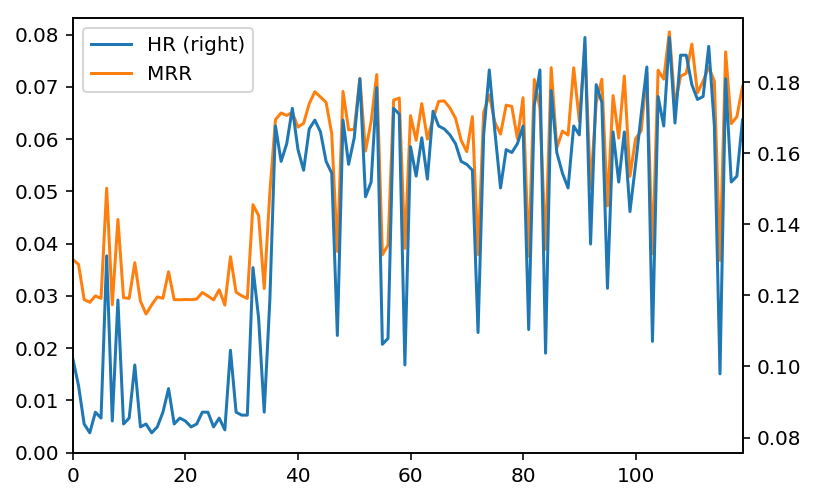

In [195]:
grid_results_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

In [200]:
grid_results_df.loc[lambda x: x.MRR == x.MRR.max()]

,,,,,,,HR,MRR,COV
"(sss, 0.3)","(r, 1e-09)","(rr, 0.001)","(r, 50)","(nsne, 50)","(lr, 3e-08)","(mi, 40)",0.192531,0.080512,681


### Fine-tuning

In [352]:
refined_params = {
          'ranking_regularization': [0.0003, 0.001, 0.003],
          'regularization':         [3e-10, 1e-9, 3e-9],
          'linear_regularization':  [1e-8, 3e-8, 1e-7],
          'sgd_step_size':          [0.3],
          'num_sampled_negative_examples': [40, 50, 60],
          'max_iterations': [40],
          'rank': [50]
         }
refined_params_grid = ParameterGrid(refined_params)
len(refined_params_grid)

81

In [ ]:
grid_results_refined = run_parameter_search(fm, data_model, metrics, refined_params_grid, verbose=False, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [ ]:
grid_results_refined_df = pd.DataFrame.from_dict(grid_results_refined, orient='index')

In [361]:
grid_results_refined_df.loc[lambda x: x.MRR > 0.95*x.MRR.max()]

HR  \
(sss, 0.3) (r, 3e-10) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-07) (mi, 40)  0.198340   
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  0.189212   
           (r, 1e-09) (rr, 0.0003) (r, 50) (nsne, 40) (lr, 3e-08) (mi, 40)  0.186722   
                                                      (lr, 1e-07) (mi, 40)  0.179253   
                                           (nsne, 60) (lr, 1e-07) (mi, 40)  0.182573   
                      (rr, 0.001)  (r, 50) (nsne, 60) (lr, 3e-08) (mi, 40)  0.193361   
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-07) (mi, 40)  0.178423   
           (r, 3e-09) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  0.192531   
                      (rr, 0.003)  (r, 50) (nsne, 50) (lr, 3e-08) (mi, 40)  0.168465   

                                                                                 MRR  \
(sss, 0.3) (r, 3e-10) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-07) (mi, 40)  0.079343   
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  0.081886   
           (r, 1e-09) (rr, 0.0003) (r, 50) (nsne, 40) (lr, 3e-08) (mi, 40)  0.078110   
                                                      (lr, 1e-07) (mi, 40)  0.078066   
                                           (nsne, 60) (lr, 1e-07) (mi, 40)  0.079784   
                      (rr, 0.001)  (r, 50) (nsne, 60) (lr, 3e-08) (mi, 40)  0.079425   
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-07) (mi, 40)  0.078338   
           (r, 3e-09) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  0.080727   
                      (rr, 0.003)  (r, 50) (nsne, 50) (lr, 3e-08) (mi, 40)  0.078238   

                                                                            COV  
(sss, 0.3) (r, 3e-10) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-07) (mi, 40)  668  
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  725  
           (r, 1e-09) (rr, 0.0003) (r, 50) (nsne, 40) (lr, 3e-08) (mi, 40)  683  
                                                      (lr, 1e-07) (mi, 40)  658  
                                           (nsne, 60) (lr, 1e-07) (mi, 40)  716  
                      (rr, 0.001)  (r, 50) (nsne, 60) (lr, 3e-08) (mi, 40)  759  
                      (rr, 0.003)  (r, 50) (nsne, 60) (lr, 1e-07) (mi, 40)  653  
           (r, 3e-09) (rr, 0.001)  (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  697  
                      (rr, 0.003)  (r, 50) (nsne, 50) (lr, 3e-08) (mi, 40)  642

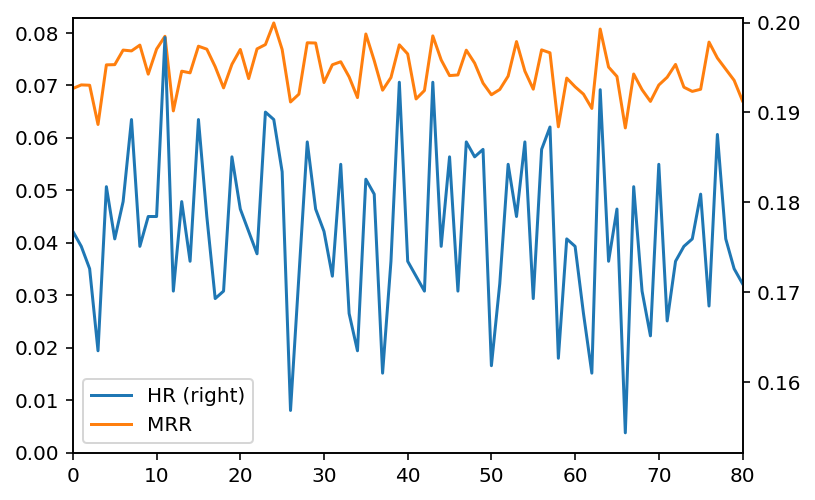

In [362]:
grid_results_refined_df[['HR', 'MRR']].reset_index(drop=True).plot(secondary_y='HR', ylim=(0, None))

In [403]:
grid_results_refined_df.loc[lambda x: x.MRR > 0.08]

HR  \
(sss, 0.3) (r, 3e-10) (rr, 0.003) (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  0.189212   
           (r, 3e-09) (rr, 0.001) (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  0.192531   

                                                                                MRR  \
(sss, 0.3) (r, 3e-10) (rr, 0.003) (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  0.081886   
           (r, 3e-09) (rr, 0.001) (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  0.080727   

                                                                           COV  
(sss, 0.3) (r, 3e-10) (rr, 0.003) (r, 50) (nsne, 60) (lr, 1e-08) (mi, 40)  725  
           (r, 3e-09) (rr, 0.001) (r, 50) (nsne, 40) (lr, 1e-08) (mi, 40)  697

### Final

In [398]:
final_params = {
          'ranking_regularization': 0.003,
          'regularization':         3e-10,
          'linear_regularization':  1e-8,
          'sgd_step_size':          0.3,
          'num_sampled_negative_examples': 60,
          'max_iterations': 70, # increased for better results
          'rank': 50,
         }

In [399]:
final_res = run_parameter_search(fm, data_model, metrics, [final_params], verbose=True, seed=seed)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 574072 observations with 6037 users and 3530 items.

Data prepared in: 0.775751s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 50       |

| regularization                 | L2 Regularization on Factors                     | 3e-10    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-08    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.003    |

| num_sampled_negative_examples  | # Negative Samples Considered per Observation    | 60       |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| sgd_step_size                  | Starting SGD Step Size                           | 0.3      |

| max_iterations                 | Maximum Number of Iterations                     | 70       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD (step size tuning: OFF).

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 151us        | 1.62767           | 0.31328                           |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 7.95s        | DIVERGED          | DIVERGED                          | 0.3         |

| RESET   | 11.84s       | 1.62765           | 0.313251                          |             |

| 1       | 19.69s       | DIVERGED          | DIVERGED                          | 0.15        |

| RESET   | 23.59s       | 1.62768           | 0.313276                          |             |

| 1       | 27.60s       | 1.31493           | 0.641861                          | 0.075       |

| 2       | 31.61s       | 1.4184            | 0.706269                          | 0.0445953   |

| 3       | 35.64s       | 1.38283           | 0.691102                          | 0.0329019   |

| 4       | 39.66s       | 1.37335           | 0.68949                           | 0.0222976   |

| 5       | 43.73s       | 1.36189           | 0.685791                          | 0.0158606   |

| 6       | 47.78s       | 1.35102           | 0.680339                          | 0.0138335   |

| 7       | 51.80s       | 1.34438           | 0.677448                          | 0.0123232   |

| 8       | 55.87s       | 1.33747           | 0.674713                          | 0.0111488   |

| 9       | 59.89s       | 1.33002           | 0.670876                          | 0.0102062   |

| 10      | 1m 3s        | 1.32692           | 0.670415                          | 0.00943075  |

| 11      | 1m 8s        | 1.31898           | 0.666599                          | 0.00878015  |

| 12      | 1m 12s       | 1.3151            | 0.665147                          | 0.00822546  |

| 13      | 1m 16s       | 1.30853           | 0.662138                          | 0.0077462   |

| 14      | 1m 20s       | 1.30121           | 0.658559                          | 0.00732741  |

| 15      | 1m 24s       | 1.29477           | 0.655903                          | 0.00695789  |

| 16      | 1m 28s       | 1.29275           | 0.655674                          | 0.00662913  |

| 17      | 1m 32s       | 1.28676           | 0.653109                          | 0.00633446  |

| 18      | 1m 36s       | 1.28262           | 0.651259                          | 0.00606865  |

| 19      | 1m 40s       | 1.27926           | 0.649813                          | 0.00582748  |

| 20      | 1m 44s       | 1.27204           | 0.64667                           | 0.00560756  |

| 21      | 1m 48s       | 1.26949           | 0.645555                          | 0.00540607  |

| 22      | 1m 52s       | 1.26397           | 0.643266                          | 0.00522071  |

| 23      | 1m 56s       | 1.26125           | 0.641951                          | 0.00504952  |

| 24      | 2m 0s        | 1.25909           | 0.641434                          | 0.00489089  |

| 25      | 2m 4s        | 1.25507           | 0.639874                          | 0.00474342  |

| 26      | 2m 8s        | 1.25262           | 0.638953                          | 0.00460592  |

| 27      | 2m 12s       | 1.24743           | 0.636264                          | 0.00447737  |

| 28      | 2m 16s       | 1.24732           | 0.637251                          | 0.0043569   |

| 29      | 2m 20s       | 1.24252           | 0.634603                          | 0.00424373  |

| 30      | 2m 24s       | 1.24198           | 0.634846                          | 0.00413719  |

| 31      | 2m 28s       | 1.24049           | 0.634634                          | 0.00403669  |

| 32      | 2m 32s       | 1.23802           | 0.633531                          | 0.0039417   |

| 33      | 2m 36s       | 1.2363            | 0.633157                          | 0.00385177  |

| 34      | 2m 40s       | 1.23572           | 0.632957                          | 0.00376649  |

| 35      | 2m 45s       | 1.23391           | 0.632331                          | 0.00368549  |

| 36      | 2m 49s       | 1.23083           | 0.630942                          | 0.00360844  |

| 37      | 2m 53s       | 1.23008           | 0.630883                          | 0.00353505  |

| 38      | 2m 57s       | 1.22909           | 0.63079                           | 0.00346504  |

| 39      | 3m 1s        | 1.22684           | 0.629929                          | 0.00339819  |

| 40      | 3m 5s        | 1.22658           | 0.629819                          | 0.00333427  |

| 41      | 3m 9s        | 1.22536           | 0.629509                          | 0.00327309  |

| 42      | 3m 13s       | 1.22431           | 0.628828                          | 0.00321447  |

| 43      | 3m 17s       | 1.22306           | 0.628717                          | 0.00315824  |

| 44      | 3m 21s       | 1.22163           | 0.628104                          | 0.00310425  |

| 45      | 3m 25s       | 1.22158           | 0.628543                          | 0.00305237  |

| 46      | 3m 29s       | 1.22061           | 0.62799                           | 0.00300246  |

| 47      | 3m 33s       | 1.21887           | 0.627367                          | 0.00295442  |

| 48      | 3m 37s       | 1.21788           | 0.626956                          | 0.00290814  |

| 49      | 3m 41s       | 1.2176            | 0.627042                          | 0.00286351  |

| 50      | 3m 45s       | 1.21655           | 0.626608                          | 0.00282045  |

| 51      | 3m 49s       | 1.2156            | 0.626182                          | 0.00277887  |

| 52      | 3m 53s       | 1.21526           | 0.626379                          | 0.0027387   |

| 53      | 3m 57s       | 1.21264           | 0.625446                          | 0.00269985  |

| 54      | 4m 1s        | 1.21291           | 0.625331                          | 0.00266226  |

| 55      | 4m 5s        | 1.20989           | 0.62415                           | 0.00220809  |

| 56      | 4m 9s        | 1.20741           | 0.623296                          | 0.00183185  |

| 57      | 4m 13s       | 1.20577           | 0.622458                          | 0.00152008  |

| 58      | 4m 18s       | 1.2054            | 0.622525                          | 0.00150039  |

| 59      | 4m 22s       | 1.20446           | 0.621997                          | 0.00148127  |

| 60      | 4m 26s       | 1.20388           | 0.621897                          | 0.00146272  |

| 61      | 4m 30s       | 1.20294           | 0.621615                          | 0.0014447   |

| 62      | 4m 34s       | 1.20313           | 0.621519                          | 0.00142718  |

| 63      | 4m 38s       | 1.20106           | 0.620945                          | 0.0011858   |

| 64      | 4m 42s       | 1.19924           | 0.619923                          | 0.000985425 |

| 65      | 4m 46s       | 1.19771           | 0.619474                          | 0.000819061 |

| 66      | 4m 50s       | 1.19752           | 0.619092                          | 0.000809736 |

| 67      | 4m 54s       | 1.19712           | 0.619289                          | 0.000800655 |

| 68      | 4m 58s       | 1.19682           | 0.618971                          | 0.000791807 |

| 69      | 5m 2s        | 1.19646           | 0.618975                          | 0.000783185 |

| 70      | 5m 6s        | 1.19628           | 0.618857                          | 0.000774779 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 1.42012

Final training Predictive Error: 0.614962

FM training time: 314.861347s


recommendations finished on 1000/1205 queries. users per second: 6222.93

In [400]:
final_res

{(('sss', 0.3),
  ('r', 3e-10),
  ('rr', 0.003),
  ('r', 50),
  ('nsne', 60),
  ('lr', 1e-08),
  ('mi', 70)): {'COV': 866,
  'HR': 0.195850622406639,
  'MRR': 0.07939669367055259}}

Saving best config

In [404]:
pd.Series(dict(binary_target = True,
               solver = 'sgd',
               ranking_optimization = True,
               verbose = False,
               seed = seed,
               name = 'FM',
               **final_params)).to_csv('FM_ML_standard_best_config.csv')

## Cross-validation

In [ ]:
metrics = 'HR MRR COV'.split()
ranks = [1, 5, 10, 15, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200, 300, 500, 750, 1000, 1500, 2000, 3200]

fm_cv_results = run_cv_experiment([fm], data_model, metrics, ('rank', ranks), verbose=False)

A Jupyter Widget

Data is ready. No action was taken.


Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [416]:
fm_rank_cv_results = get_results_dataframe(fm_cv_results, ('rank', ranks))

In [417]:
fm_rank_cv_results.to_csv('Standard_FM_CV_results_ML.csv')

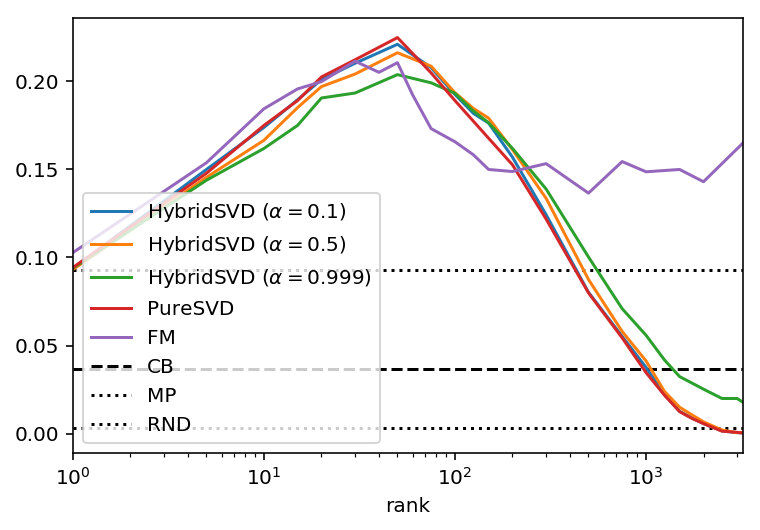

In [418]:
metric = 'HR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

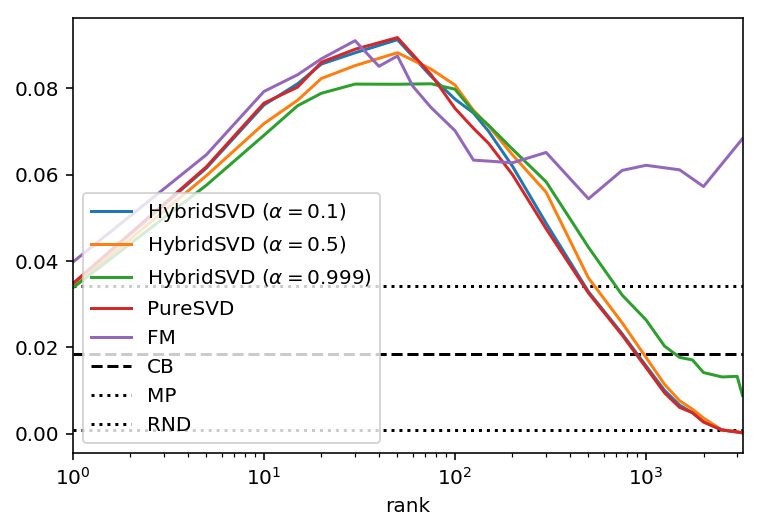

In [419]:
metric = 'MRR'
ax = rank_cv_results.xs(metric, 1, 1).mean(level='rank').plot(logx=True)

fm_rank_cv_results.xs(metric, 1, 1).mean(level=1).plot(ax=ax, label='FM')

linestyles = {'CB': '--', 'RND': ':', 'MP': ':'}
colors = {'CB': '', 'RND': '', 'MP': ''}

for col, data in base_cv_results.xs(metric, 1, 1).mean(level='rank').iteritems():
    ax.hlines(y=data, xmin=1, xmax=3200, label=col, linestyles=linestyles[col])
ax.legend()

In [420]:
rank_cv_results.loc[:, ('PureSVD', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
50    0.091713
Name: (PureSVD, MRR), dtype: float64

In [421]:
fm_rank_cv_results.loc[:, ('FM', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
30    0.090997
Name: (FM, MRR), dtype: float64

In [433]:
rank_cv_results.loc[:, (r'HybridSVD ($\alpha=0.1$)', 'MRR')].mean(level='rank').loc[lambda x: x == x.max()]

rank
50    0.091224
Name: (HybridSVD ($\alpha=0.1$), MRR), dtype: float64

# Top-N experiments

In [441]:
def sample_ci(df, coef=2.776, level=None): # 95% CI for sample
    return coef * df.std(level=level) / np.sqrt(df.shape[0])

In [444]:
hsvd = [hybrid_svd for hybrid_svd in hybrids if '0.5' in hybrid_svd.method][0]

In [445]:
topk_models = baselines + [psvd, fm, hsvd]
models_config = [None]*len(baselines) + [{'rank':50}, {'rank':30}, {'rank':50}]

for model in topk_models:
    print model.method,

MP RND CB PureSVD FM HybridSVD ($\alpha=0.5$)


In [437]:
topk_list = [1, 3, 10, 20, 30]

topk_cv_results = run_cv_experiment(topk_models, data_model, metrics, ('topk', topk_list), models_configuration=models_config, verbose=False)

A Jupyter Widget

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

Recsys training: model = ranking_factorization_recommender

In [450]:
topk_list = [1, 3, 10, 20, 30]

hsvd_topk_cv_results = run_cv_experiment([hsvd], data_model, metrics, ('topk', topk_list), verbose=False)

A Jupyter Widget

In [453]:
topk_cv_results.update(hsvd_topk_cv_results)

In [438]:
topk_cv_results_df = get_results_dataframe(topk_cv_results, ('topk', topk_list))

In [439]:
topk_cv_results_df.to_csv('Standard_TopN_CV_results_ML.csv')

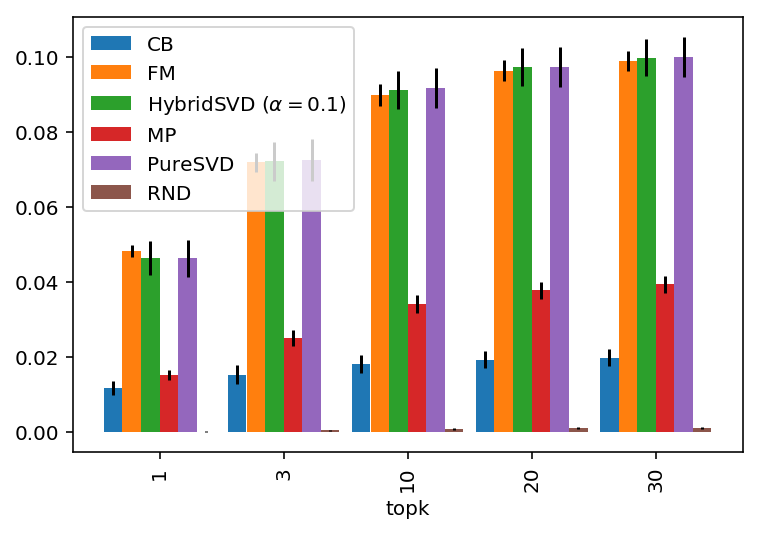

In [456]:
topk_cv_results_df.xs('MRR', 1, 1).mean(level='topk').plot.bar(yerr=sample_ci(topk_cv_results_df.xs('MRR', 1, 1), level='topk'), width=0.9, logy=False)